In [12]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
from matplotlib import path

import os

%matplotlib inline

## 1 Select a grayscale image

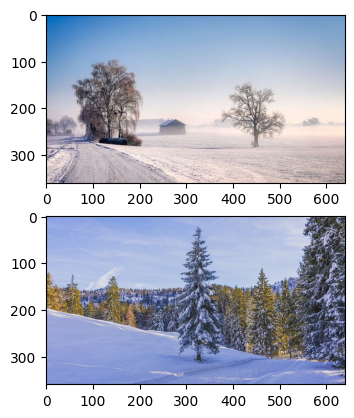

In [13]:
src_image = plt.imread('snow.jpg')
dst_image = plt.imread('pine.jpg')


height, width, ch = src_image.shape

fig, ax = plt.subplots(2, 1)
ax[0].imshow(src_image)
ax[1].imshow(dst_image)

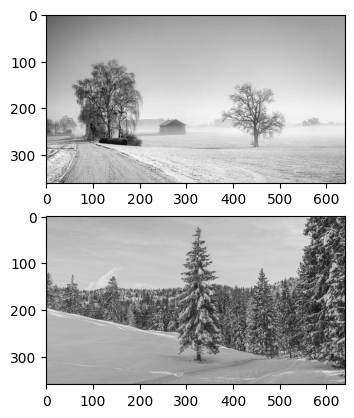

In [14]:
src_image_gray = np.round(np.mean(src_image, axis=2)).astype(np.uint8)
dst_image_gray = np.round(np.mean(dst_image, axis=2)).astype(np.uint8)

fig, ax = plt.subplots(2, 1)
ax[0].imshow(src_image_gray, cmap='gray')
ax[1].imshow(dst_image_gray, cmap='gray')

In [53]:
def inPoly(points, poly):
    
    return path.Path(poly).contains_points(points, radius=1e-8)

In [109]:

mask_rev = np.array([
    [100, 80],
    [80, 120],
    [100, 210],
    [290, 210],
    [280, 120],
    [270, 70],
    [150, 50]
])
mask = mask_rev.copy()
mask[:, 0] = mask_rev[:, 1]
mask[:, 1] = mask_rev[:, 0]


In [57]:
X, Y = np.meshgrid(np.linspace(0, height - 1, height), np.linspace(0, width - 1, width))
X = X[:, :, np.newaxis]
Y = Y[:, :, np.newaxis]
cor = np.concatenate((Y, X), axis=2)
cor_flat = cor.reshape((height * width, 2))

[[  1   1]
 [  0   0]
 [360 640]]
[False False False]


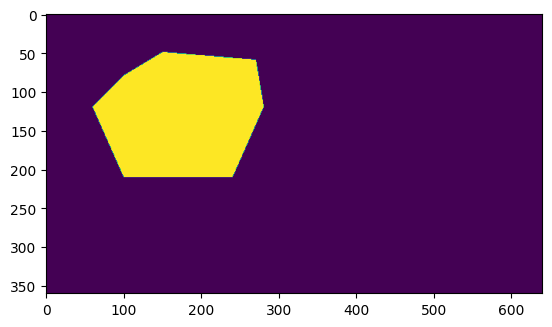

In [89]:
b = np.array([False, True, False])
a = np.array([
        [1,1],
        [300,640],
        [360, 640]
    ]
).astype(np.int32)
a[b] = np.array([0,0])
print(a)
print(inPoly(a, mask))

plt.imshow(mask_image)
plt.show()

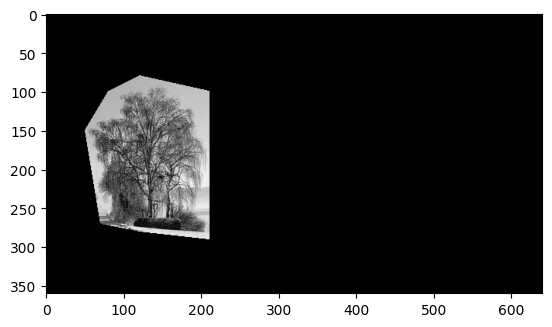

In [110]:
mask_image = np.zeros((height, width))
mask_image = cv2.fillConvexPoly(mask_image, mask, 1.0)
meshed_image = src_image_gray.copy().astype(np.float32)
meshed_image *= mask_image.astype(np.float32)
meshed_image = meshed_image.astype(np.uint8)
plt.imshow(meshed_image, cmap='gray')
plt.show()